In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from datasets import load_dataset
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import librosa

In [2]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

In [3]:

# Specify the root folder that contains sub-folders with audio files
root = '..\\..\\sound-propagation-simulation\\dataset\\2023-03-22 11-50-31'

# Create empty lists to store waveforms, sample rates and labels
waveforms = []
sample_rates = []
labels = []

# Loop over the sub-folders in the root folder
for folder in os.listdir(root):
    # Get the label from the folder name
    label = folder
    # Loop over the audio files in each sub-folder
    for filename in glob.glob(os.path.join(root, folder, '*stereo.wav')):
        try:
            # Load an audio file as a tensor and its sample rate
            waveform, sample_rate = torchaudio.load(filename)
            # Append them to the lists
            waveforms.append(waveform)
            sample_rates.append(sample_rate)
            labels.append(label)
        except Exception as e:
            print(e)
print(labels)

['StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 

In [4]:
print("Number of waveforms: ", len(waveforms))
print("number of labels: ", len(labels))

Number of waveforms:  558
number of labels:  558


In [5]:
# append second channel after the end of first channel
waveforms_cropped = [torch.cat((waveform, waveform), 1) for waveform in waveforms]
# remove second channel
waveforms_cropped = [waveform[0] for waveform in waveforms_cropped]
print(len(waveforms_cropped))
labels = [label for label, waveform in zip(labels, waveforms_cropped)]
print(labels)


558
['StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint2', 'StartPoint1_StartPoint

In [6]:
# create tensors from the lists
waveforms_tensor = torch.stack(waveforms_cropped)
sample_rates = torch.tensor(sample_rates)
print(waveforms_tensor.shape)
# convert the labels to integers
label_to_int = {label: i for i, label in enumerate(set(labels))}
int_labels = [label_to_int[label] for label in labels]
int_labels = torch.tensor(int_labels)
print(int_labels.shape)
# print number of classes
print("Number of classes: ", len(set(labels)))



torch.Size([558, 172800])
torch.Size([558])
Number of classes:  12


torch.Size([558, 51, 136])


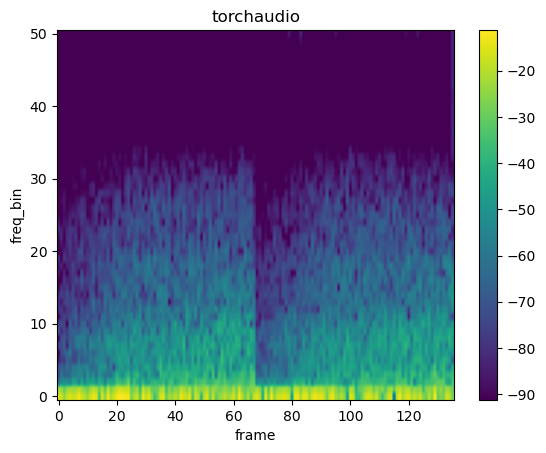

StartPoint1_StartPoint2
torch.Size([558, 1, 51, 136])


In [7]:
# convert the waveforms to log based spectrograms
#spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(400), n_fft=400, hop_length=160, win_length=400, power=2.0, normalized=True) for waveform in waveforms_tensor]
spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(100), n_fft=100, hop_length=1280, win_length=100, power=2.0, normalized=True) for waveform in waveforms_tensor]
spectrograms = torch.stack(spectrograms)
print(spectrograms.shape)
idx=10
plot_spectrogram(spectrograms[idx], title="torchaudio")
print(labels[idx])
# add a channel dimension
spectrograms = spectrograms.unsqueeze(1)
print(spectrograms.shape)

In [8]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(spectrograms, int_labels)
# split the dataset into labels and features
X = dataset.tensors[0]
y = dataset.tensors[1]

# split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)

torch.Size([446, 1, 51, 136])
torch.Size([112, 1, 51, 136])


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# input shape (191, 2, 201, 276)
# output shape (1, 4)
import torch
import torch.nn as nn


""" class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 2 classes
        self.out = nn.Linear(32 * 7 * 7, 2) """

# cnn for input shape torch.Size([227, 1, 51, 69])
# output shape torch.Size([227, 2])
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 2 classes
        self.out = nn.Linear(3264, len(set(labels)))
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization


model = CNN()
# summary(model, (1, 51, 69))
summary(model, X_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 25, 68]           --
|    └─Conv2d: 2-1                       [-1, 8, 51, 136]          208
|    └─ReLU: 2-2                         [-1, 8, 51, 136]          --
|    └─MaxPool2d: 2-3                    [-1, 8, 25, 68]           --
├─Sequential: 1-2                        [-1, 16, 12, 34]          --
|    └─Conv2d: 2-4                       [-1, 16, 25, 68]          3,216
|    └─ReLU: 2-5                         [-1, 16, 25, 68]          --
|    └─MaxPool2d: 2-6                    [-1, 16, 12, 34]          --
├─Sequential: 1-3                        [-1, 32, 6, 17]           --
|    └─Conv2d: 2-7                       [-1, 32, 12, 34]          12,832
|    └─ReLU: 2-8                         [-1, 32, 12, 34]          --
|    └─MaxPool2d: 2-9                    [-1, 32, 6, 17]           --
├─Linear: 1-4                            [-1, 12]                  39,180
Tot

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 25, 68]           --
|    └─Conv2d: 2-1                       [-1, 8, 51, 136]          208
|    └─ReLU: 2-2                         [-1, 8, 51, 136]          --
|    └─MaxPool2d: 2-3                    [-1, 8, 25, 68]           --
├─Sequential: 1-2                        [-1, 16, 12, 34]          --
|    └─Conv2d: 2-4                       [-1, 16, 25, 68]          3,216
|    └─ReLU: 2-5                         [-1, 16, 25, 68]          --
|    └─MaxPool2d: 2-6                    [-1, 16, 12, 34]          --
├─Sequential: 1-3                        [-1, 32, 6, 17]           --
|    └─Conv2d: 2-7                       [-1, 32, 12, 34]          12,832
|    └─ReLU: 2-8                         [-1, 32, 12, 34]          --
|    └─MaxPool2d: 2-9                    [-1, 32, 6, 17]           --
├─Linear: 1-4                            [-1, 12]                  39,180
Tot

In [10]:
from torch.utils.tensorboard import SummaryWriter
import datetime
import tqdm


In [11]:
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter('runs_2/'+time)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(torch.cuda.get_device_name(0))

# Create a CNN model
model = CNN()
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Train the model
batch_size = 128
num_epochs = 10_000
model.to(device)
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i in range(0,len(train_loader), batch_size):
        # Get the inputs and labels
        inputs, labels = next(iter(train_loader))
        # Forward pass
        outputs,x = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        test_loss = 0
        correct = 0
        total = 0
        for i in range(0,len(test_loader), batch_size):
            inputs, labels = next(iter(test_loader))
            outputs, x = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        writer.add_scalar('loss/train', loss.item(), epoch)
        writer.add_scalar('loss/test', test_loss, epoch)
        writer.add_scalar('accuracy/test', 100 * correct / total, epoch)
        writer.add_scalar('accuracy/train', (outputs.argmax(1) == labels).sum().item() / len(labels) * 100, epoch)
        print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch+1, loss.item(),(outputs.argmax(1) == labels).sum().item() / len(labels) * 100, test_loss, 100 * correct / total))
    if (epoch+1)%20000 == 0:
        print('Model saved to model_{}.ckpt'.format(epoch+1))
        torch.save(model.state_dict(), 'models/{}model_{}.ckpt'.format(time,epoch+1))
    #print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, loss.item(),(outputs.argmax(1) == labels).sum().item() / len(labels) * 100))


NVIDIA GeForce RTX 4070 Ti
Epoch: 100, Loss: 2.3882, Accuracy: 14.29%, Test Loss: 2.4146, Test Accuracy: 14.29%
Epoch: 200, Loss: 0.2780, Accuracy: 86.61%, Test Loss: 0.4111, Test Accuracy: 86.61%
Epoch: 300, Loss: 0.1078, Accuracy: 90.18%, Test Loss: 0.2524, Test Accuracy: 90.18%
Epoch: 400, Loss: 0.0802, Accuracy: 93.75%, Test Loss: 0.1677, Test Accuracy: 93.75%
Epoch: 500, Loss: 0.0673, Accuracy: 93.75%, Test Loss: 0.1486, Test Accuracy: 93.75%
Epoch: 600, Loss: 0.0639, Accuracy: 93.75%, Test Loss: 0.1918, Test Accuracy: 93.75%
Epoch: 700, Loss: 0.0437, Accuracy: 93.75%, Test Loss: 0.1499, Test Accuracy: 93.75%
Epoch: 800, Loss: 0.0233, Accuracy: 95.54%, Test Loss: 0.1979, Test Accuracy: 95.54%
Epoch: 900, Loss: 0.0518, Accuracy: 96.43%, Test Loss: 0.1817, Test Accuracy: 96.43%
Epoch: 1000, Loss: 0.0178, Accuracy: 94.64%, Test Loss: 0.1728, Test Accuracy: 94.64%
Epoch: 1100, Loss: 0.0184, Accuracy: 97.32%, Test Loss: 0.1466, Test Accuracy: 97.32%
Epoch: 1200, Loss: 0.0145, Accuracy:

In [17]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs,x = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {:.2f} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 100.00 %


In [ ]:
#